In [24]:
from eye_contact_frames import eye_contact_frames 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Funktionen

In [25]:
def merge_annotations_real(number_annotation, total_frames, extra_txt_names = ""):
    df_annotated = pd.Series(eye_contact_frames(f"annotations/annotations_{number_annotation}.xml", total_frames), name = "annotated")
    df = pd.read_csv(f"video_annot{number_annotation}{extra_txt_names}.txt", names = ["frame", "acc"])
    print(df_annotated.value_counts())
    merged = pd.merge(df, df_annotated, left_on = "frame", right_index=True)
    return merged

In [26]:
def density(merged):
    print(merged.shape[0], merged.frame.max())
    return f"Auf {merged.shape[0]/ merged.frame.max()*100 :.2f}% der Frames wurde ein Gesicht gefunden."


In [27]:
def view(threshold, annotations, real):
    real_rounded = [x>threshold for x in real]
    print("%.2f" %threshold,"%.3f" %accuracy_score(annotations, real_rounded), "%.3f"%balanced_accuracy_score(annotations, real_rounded))
    ConfusionMatrixDisplay(confusion_matrix(annotations, real_rounded)).plot()
    plt.show()

In [28]:
def get_df_accs(merged):
    accs = []
    baccs = []
    for threshold in np.arange(.2,1,.05):
        accs.append(accuracy_score(merged.annotated, [int(x>threshold) for x in merged.acc]))
        baccs.append(balanced_accuracy_score(merged.annotated, [int(x>threshold) for x in merged.acc]))

    df = pd.DataFrame()
    df["threshold"] = np.arange(.2,1,.05)
    df["accuracy"] = accs
    df["balanced_acc"] = baccs
    return df

# Video 2

In [55]:
merged = merge_annotations_real(2, 21000, "_output")
merged.head()

annotated
0.0    18371
1.0     2629
Name: count, dtype: int64


,frame,acc,annotated
0,181,0.712508,0.0
1,361,0.740293,0.0
2,658,0.242010,0.0
3,710,0.810450,0.0
4,710,0.617997,0.0


In [56]:
density(merged)

1517 20745


'Auf 7.31% der Frames wurde ein Gesicht gefunden.'

In [57]:
get_df_accs(merged)

,threshold,accuracy,balanced_acc
0,0.20,0.199736,0.341033
1,0.25,0.243243,0.347535
2,0.30,0.296638,0.345258
3,0.35,0.364535,0.355499
4,0.40,0.471325,0.386137
5,0.45,0.588003,0.418347
6,0.50,0.681608,0.439299
7,0.55,0.765326,0.466959
8,0.60,0.813448,0.476127
9,0.65,0.836519,0.483244


0.20 0.200 0.341


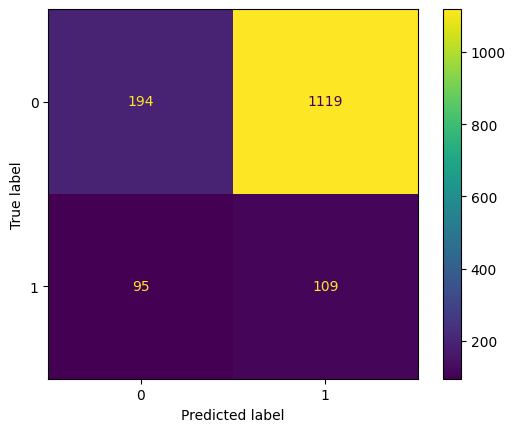

0.25 0.243 0.348


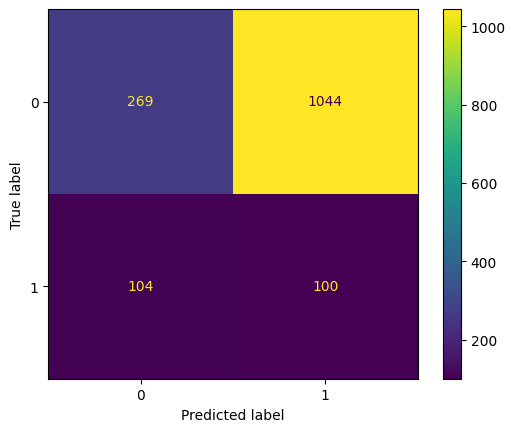

0.30 0.297 0.345


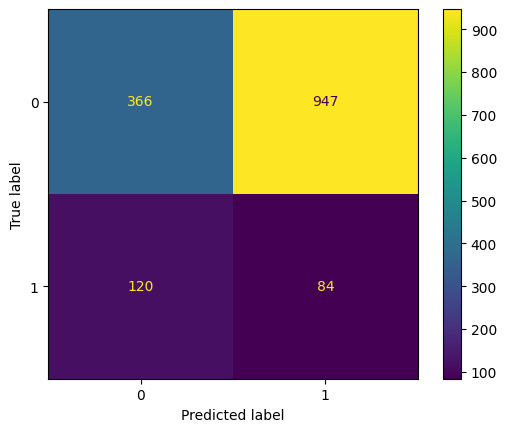

0.35 0.365 0.355


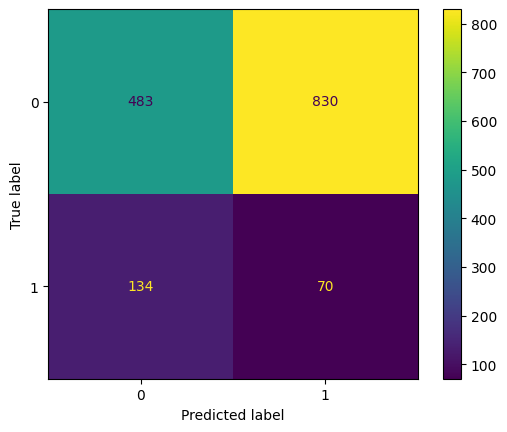

0.40 0.471 0.386


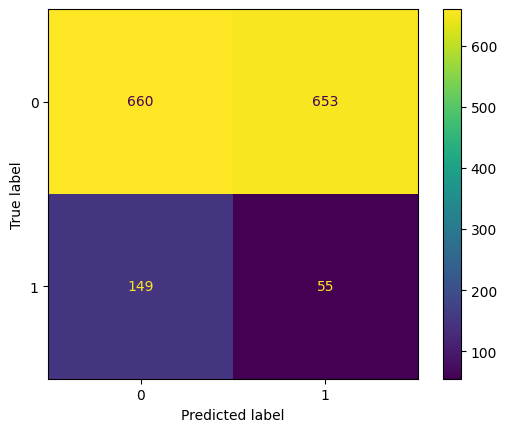

0.45 0.588 0.418


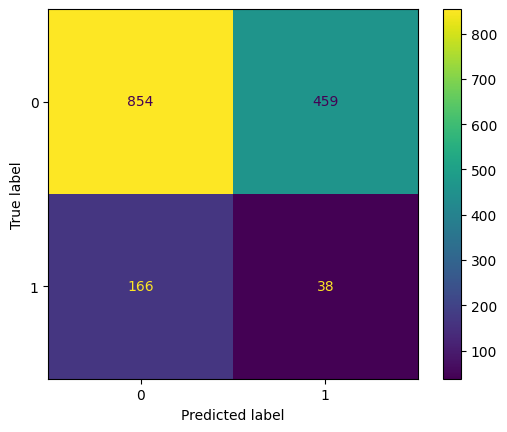

0.50 0.682 0.439


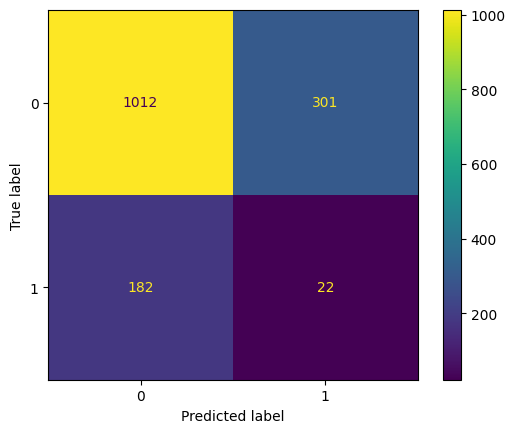

0.55 0.765 0.467


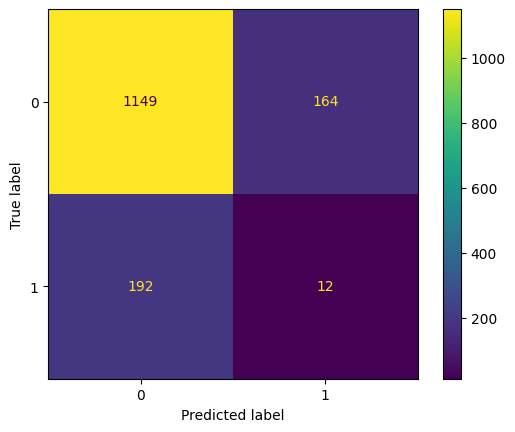

0.60 0.813 0.476


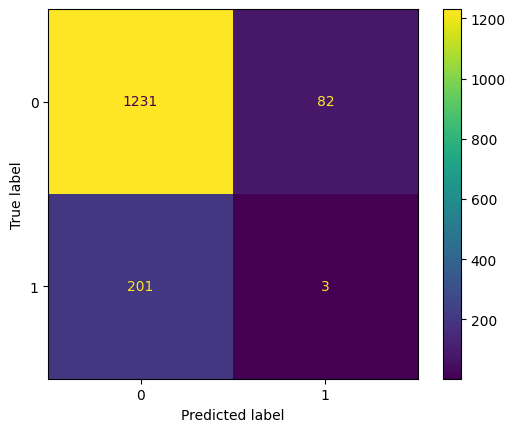

0.65 0.837 0.483


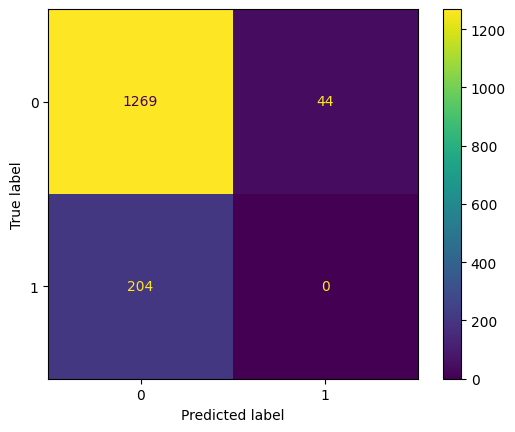

0.70 0.850 0.491


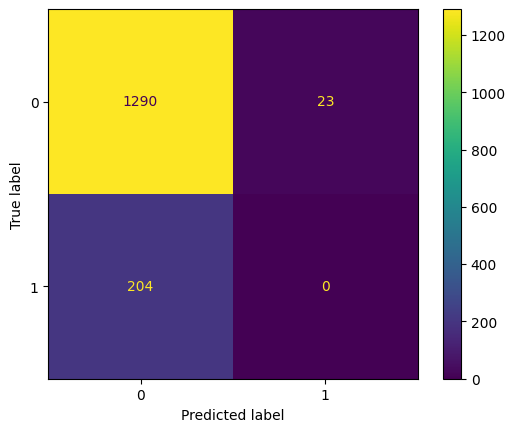

0.75 0.856 0.494


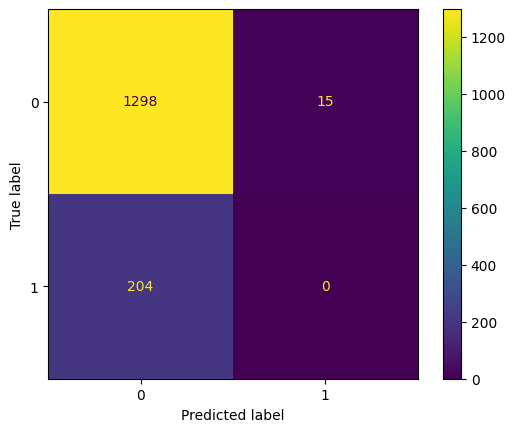

0.80 0.859 0.496


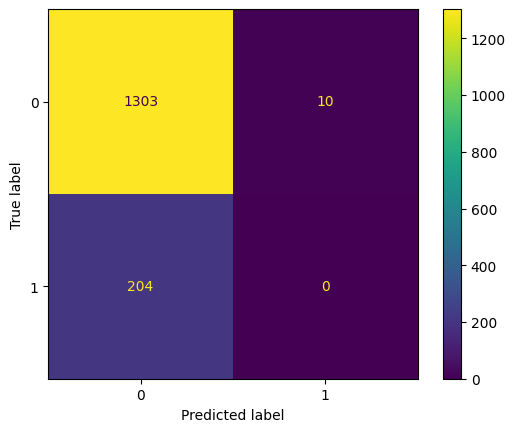

0.85 0.863 0.498


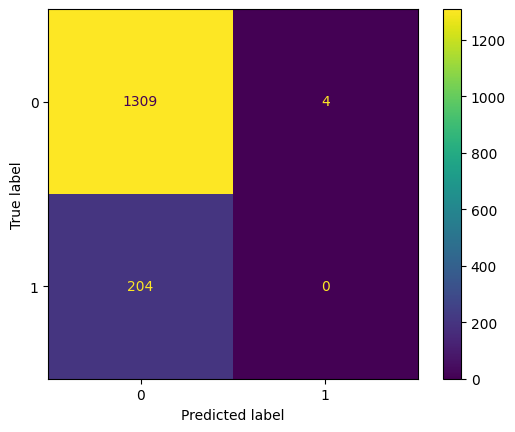

0.90 0.866 0.500


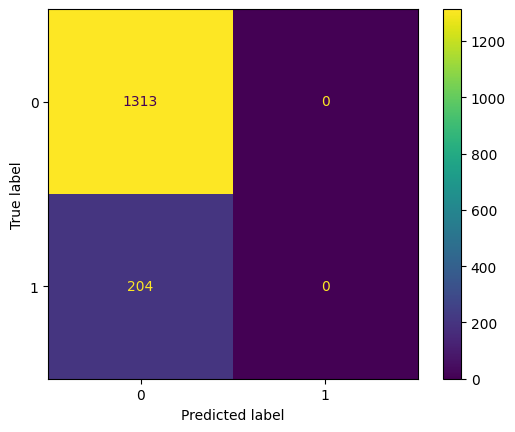

0.95 0.866 0.500


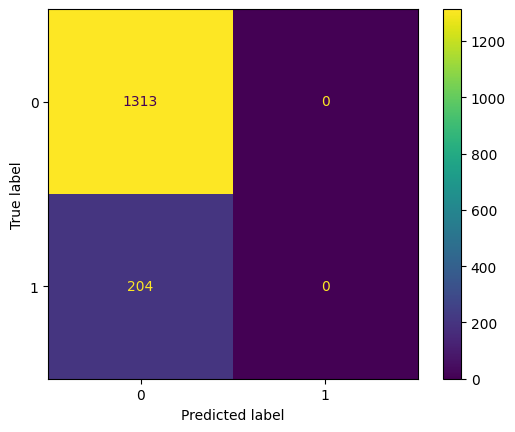

              precision    recall  f1-score   support

         0.0       0.67      0.15      0.24      1313
         1.0       0.09      0.53      0.15       204

    accuracy                           0.20      1517
   macro avg       0.38      0.34      0.20      1517
weighted avg       0.59      0.20      0.23      1517



In [58]:
for i in np.arange(.2,1,.05):
    view(i, merged.annotated, merged.acc)
print(classification_report(merged.annotated, [x>.2 for x in merged.acc]))

# Video 3

## cropped mediapipe

In [59]:
merged = merge_annotations_real(3, 17000, "_crop_output_mediapipe")
merged.head()

annotated
0.0    13960
1.0     3040
Name: count, dtype: int64


,frame,acc,annotated
0,42,0.233458,1.0
1,46,0.378733,1.0
2,48,0.477610,1.0
3,49,0.507607,1.0
4,50,0.391993,1.0


In [60]:
density(merged)

659 12545


'Auf 5.25% der Frames wurde ein Gesicht gefunden.'

In [61]:
get_df_accs(merged)

,threshold,accuracy,balanced_acc
0,0.20,0.711684,0.664728
1,0.25,0.632777,0.622646
2,0.30,0.549317,0.587271
3,0.35,0.464340,0.544632
4,0.40,0.411229,0.534214
5,0.45,0.349014,0.508708
6,0.50,0.297420,0.496054
7,0.55,0.261002,0.495879
8,0.60,0.239757,0.492345
9,0.65,0.221548,0.490674


0.20 0.712 0.665


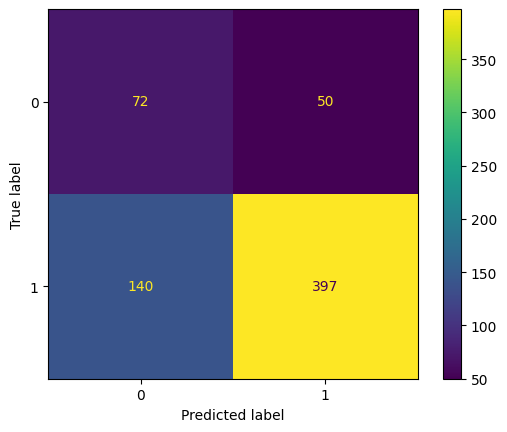

0.25 0.633 0.623


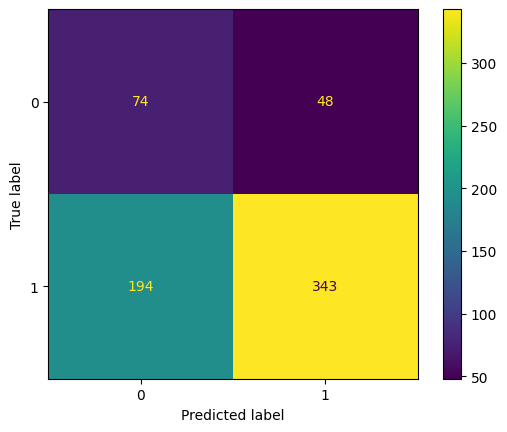

0.30 0.549 0.587


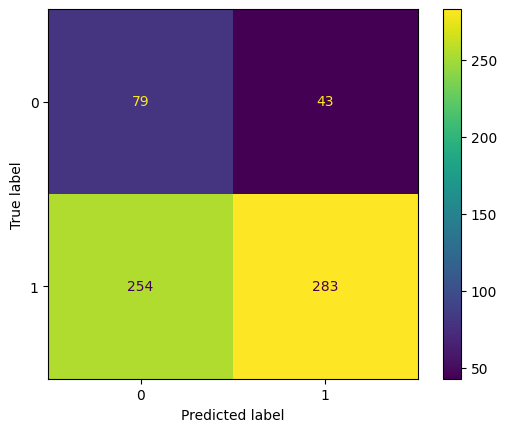

0.35 0.464 0.545


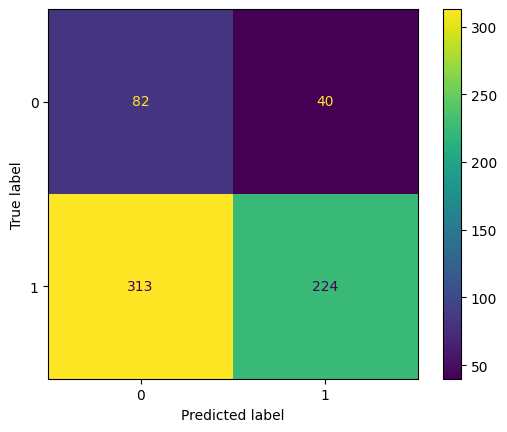

0.40 0.411 0.534


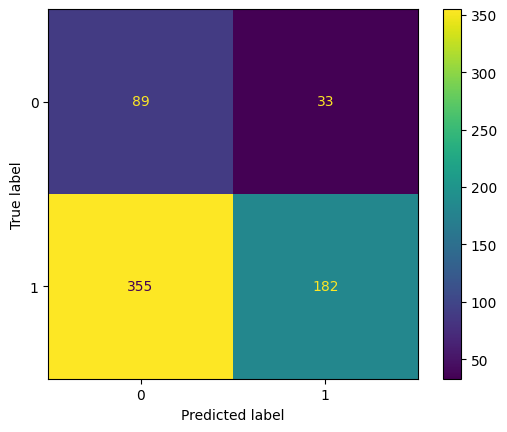

0.45 0.349 0.509


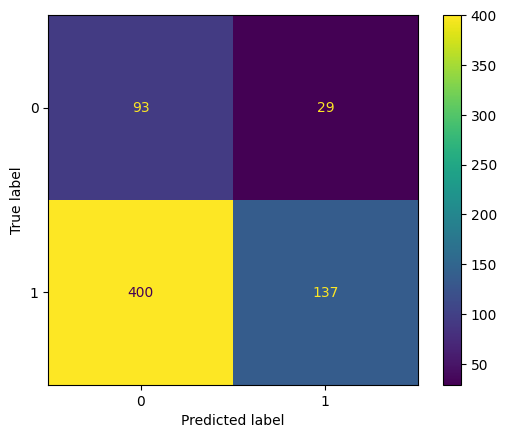

0.50 0.297 0.496


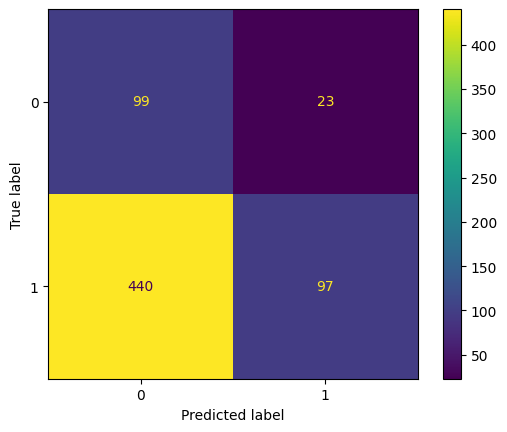

0.55 0.261 0.496


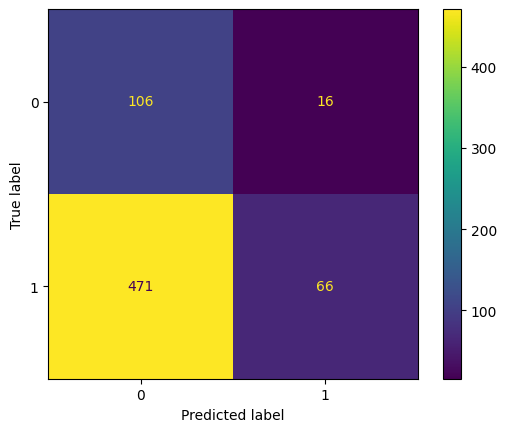

0.60 0.240 0.492


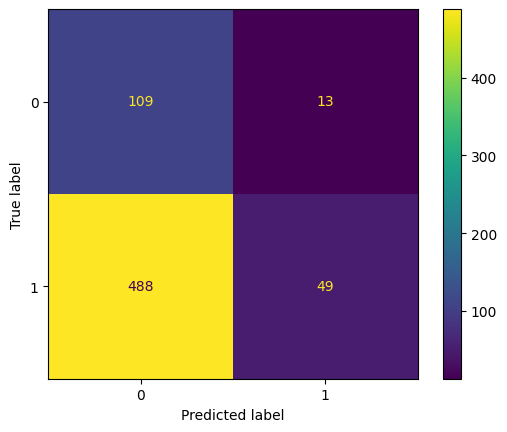

0.65 0.222 0.491


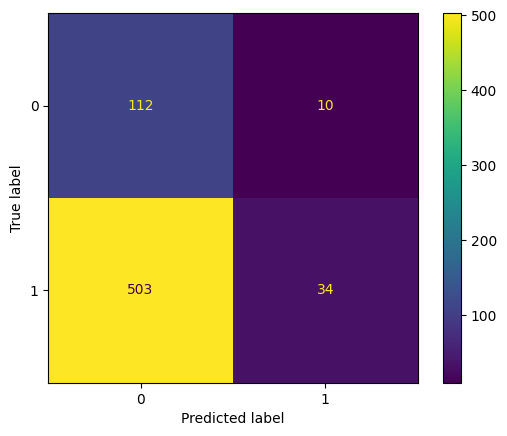

0.70 0.215 0.503


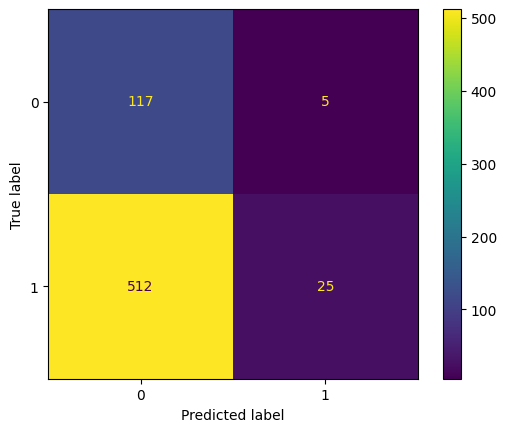

0.75 0.208 0.511


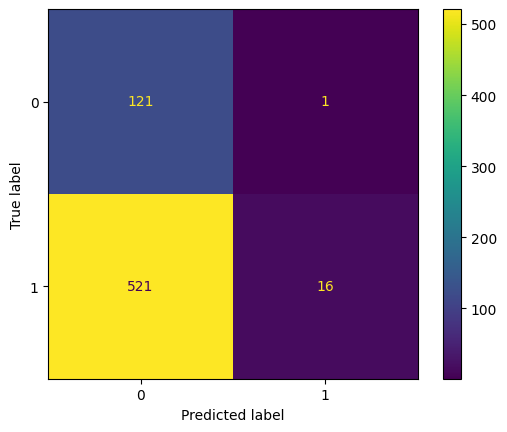

0.80 0.193 0.501


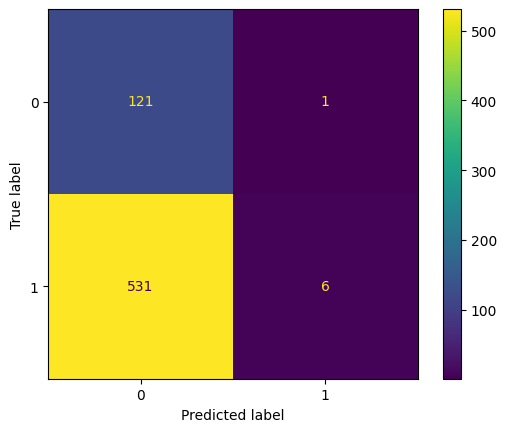

0.85 0.190 0.503


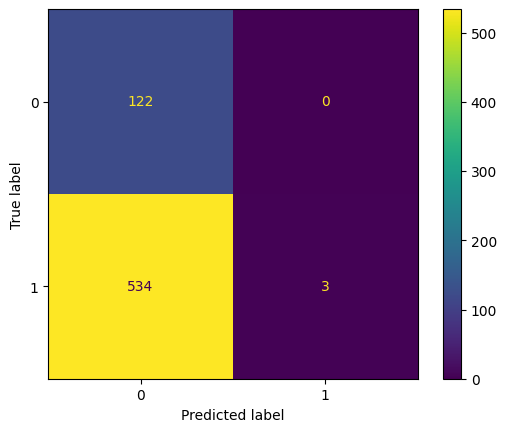

0.90 0.185 0.500


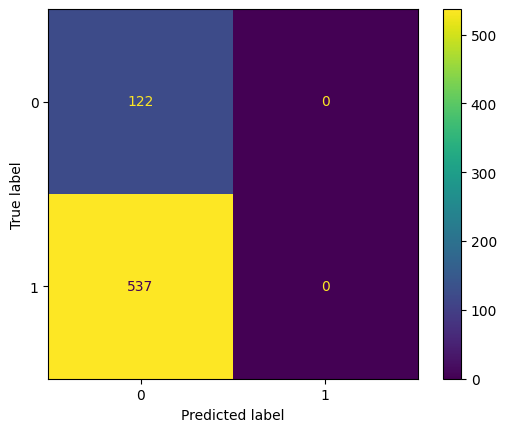

0.95 0.185 0.500


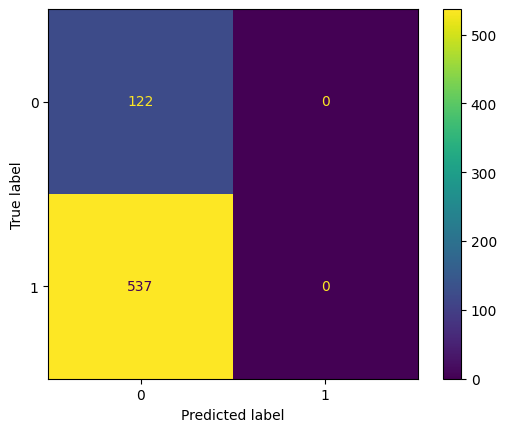

In [62]:
for i in np.arange(.2,1,.05):
    view(i, merged.annotated, merged.acc)

In [63]:
print(classification_report(merged.annotated, [x>.2 for x in merged.acc]))

              precision    recall  f1-score   support

         0.0       0.34      0.59      0.43       122
         1.0       0.89      0.74      0.81       537

    accuracy                           0.71       659
   macro avg       0.61      0.66      0.62       659
weighted avg       0.79      0.71      0.74       659



## cascade

In [64]:
merged = merge_annotations_real(3, 17000, "_output")
merged.head()

annotated
0.0    13960
1.0     3040
Name: count, dtype: int64


,frame,acc,annotated
0,2,0.853856,1.0
1,5,0.852196,1.0
2,6,0.840121,1.0
3,7,0.855735,1.0
4,8,0.900792,1.0


In [65]:
density(merged)

7 67


'Auf 10.45% der Frames wurde ein Gesicht gefunden.'

In [66]:
get_df_accs(merged)

c:\Users\jojom\miniconda3\envs\condaAP\lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\jojom\miniconda3\envs\condaAP\lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\jojom\miniconda3\envs\condaAP\lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\jojom\miniconda3\envs\condaAP\lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\jojom\miniconda3\envs\condaAP\lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred con

,threshold,accuracy,balanced_acc
0,0.20,1.000000,1.000000
1,0.25,1.000000,1.000000
2,0.30,1.000000,1.000000
3,0.35,1.000000,1.000000
4,0.40,1.000000,1.000000
5,0.45,1.000000,1.000000
6,0.50,1.000000,1.000000
7,0.55,1.000000,1.000000
8,0.60,1.000000,1.000000
9,0.65,1.000000,1.000000


0.20 1.000 1.000


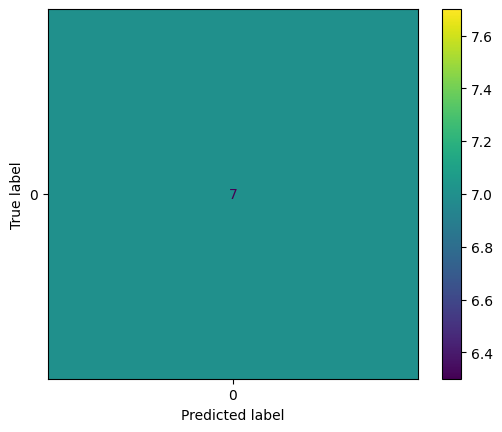

0.25 1.000 1.000


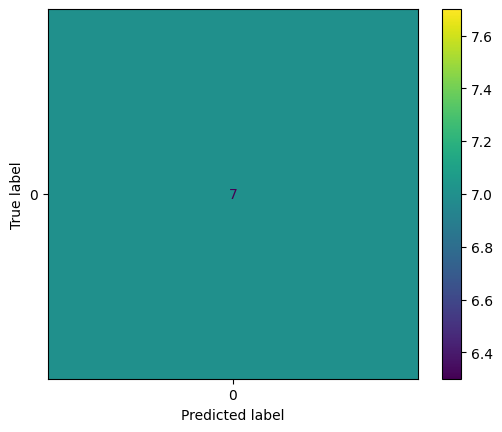

0.30 1.000 1.000


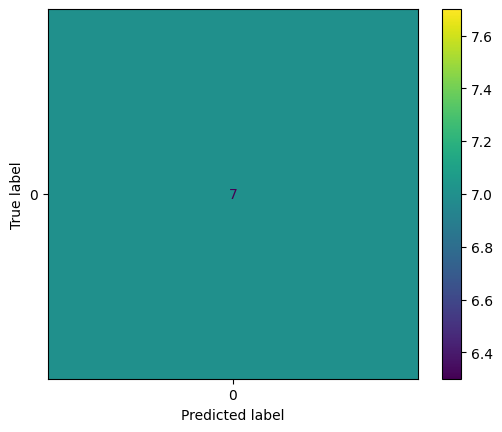

0.35 1.000 1.000


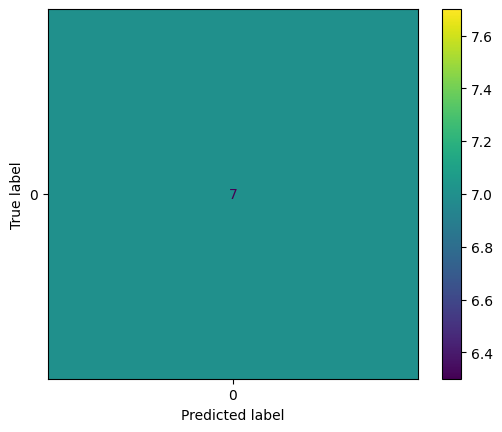

0.40 1.000 1.000


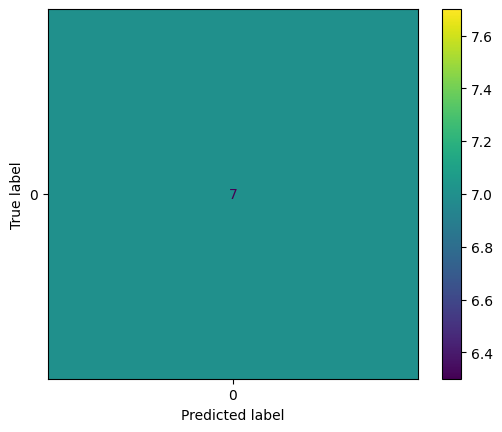

0.45 1.000 1.000


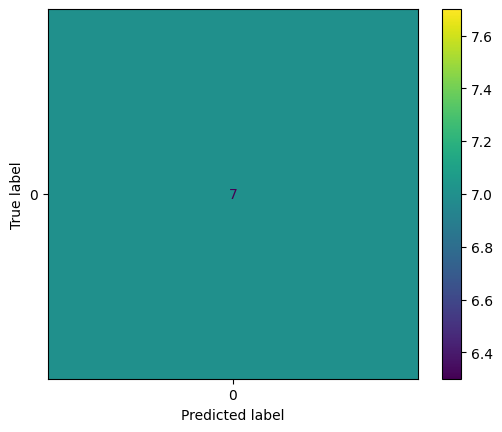

0.50 1.000 1.000


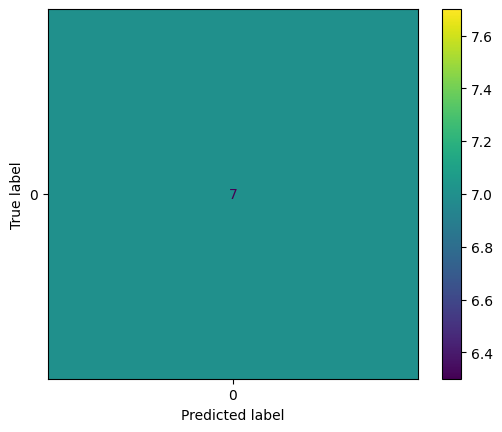

0.55 1.000 1.000


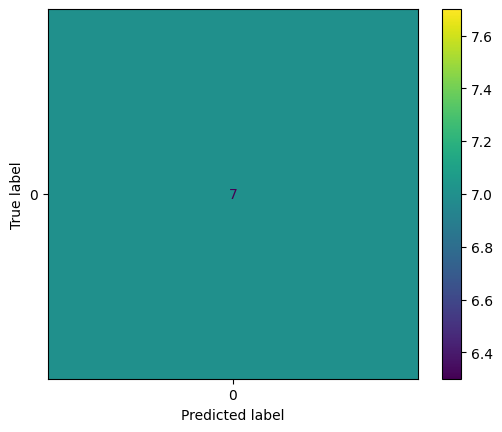

0.60 1.000 1.000


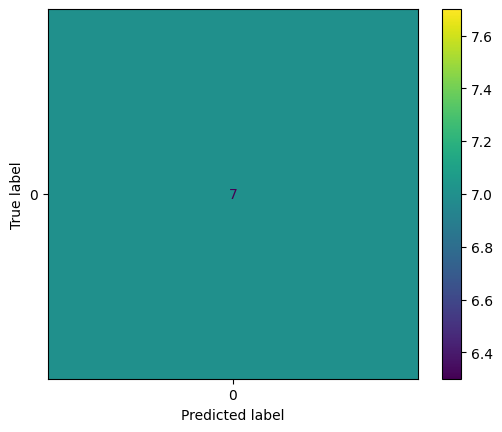

0.65 1.000 1.000


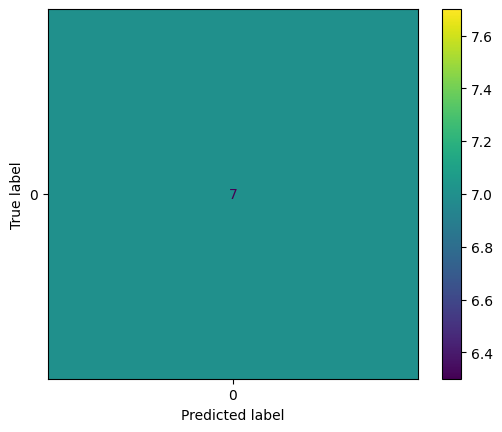

0.70 1.000 1.000


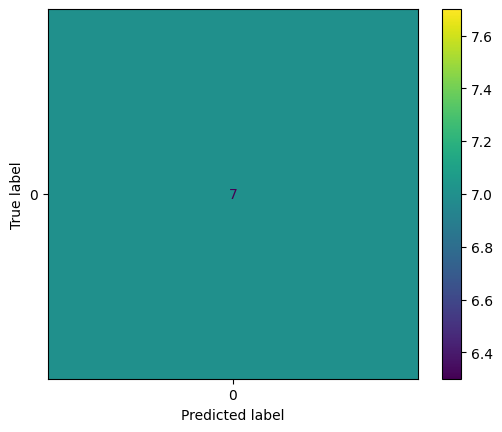

0.75 0.857 0.857


c:\Users\jojom\miniconda3\envs\condaAP\lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


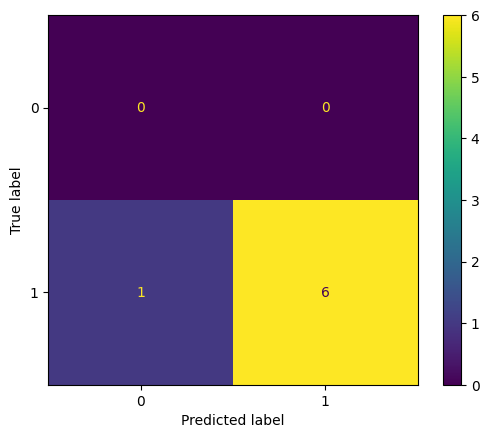

c:\Users\jojom\miniconda3\envs\condaAP\lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


0.80 0.857 0.857


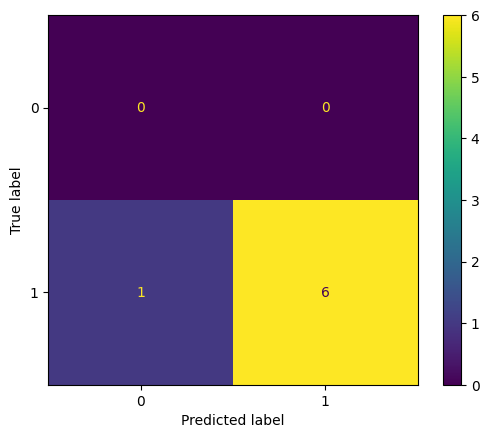

0.85 0.714 0.714


c:\Users\jojom\miniconda3\envs\condaAP\lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


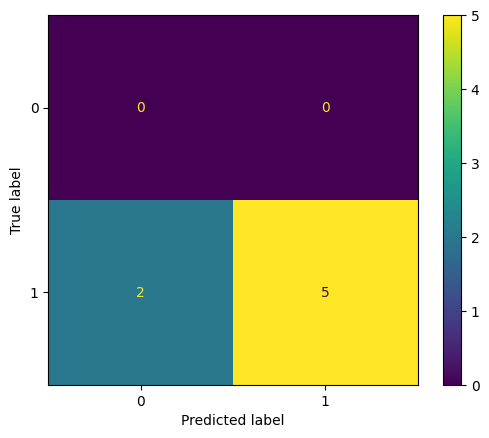

0.90 0.143 0.143


c:\Users\jojom\miniconda3\envs\condaAP\lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


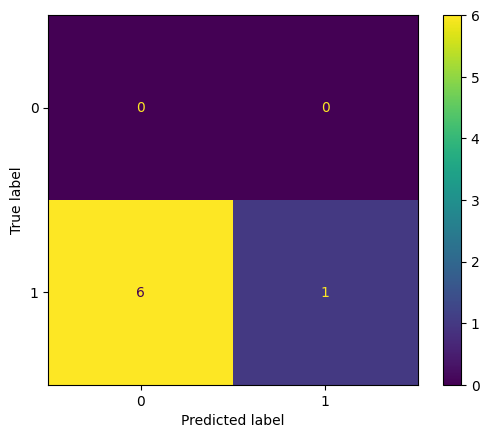

0.95 0.000 0.000


c:\Users\jojom\miniconda3\envs\condaAP\lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


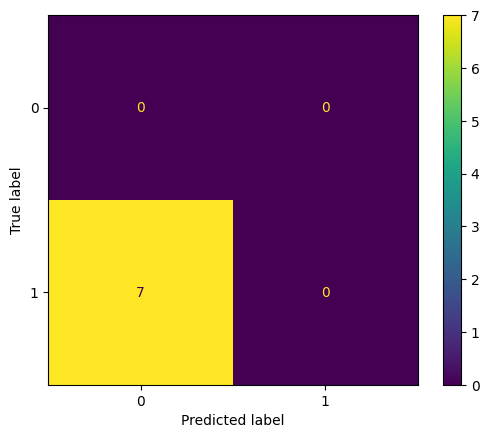

              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00         7

    accuracy                           1.00         7
   macro avg       1.00      1.00      1.00         7
weighted avg       1.00      1.00      1.00         7



In [67]:


for i in np.arange(.2,1,.05):
    view(i, merged.annotated, merged.acc)
print(classification_report(merged.annotated, [x>.2 for x in merged.acc]))

# Video 4

In [68]:
merged = merge_annotations_real(4, 20400, "_output")
merged.head()

annotated
0.0    12961
1.0     7439
Name: count, dtype: int64


,frame,acc,annotated
0,1,0.968300,0.0
1,2,0.969990,0.0
2,3,0.970669,0.0
3,4,0.955709,0.0
4,5,0.955709,0.0


In [69]:
density(merged)

7583 20397


'Auf 37.18% der Frames wurde ein Gesicht gefunden.'

In [70]:
get_df_accs(merged)

,threshold,accuracy,balanced_acc
0,0.20,0.759726,0.558983
1,0.25,0.758803,0.569462
2,0.30,0.758407,0.582934
3,0.35,0.759066,0.593235
4,0.40,0.762099,0.604062
5,0.45,0.764605,0.611367
6,0.50,0.764341,0.615066
7,0.55,0.767770,0.624219
8,0.60,0.768561,0.630910
9,0.65,0.765792,0.633643


0.20 0.760 0.559


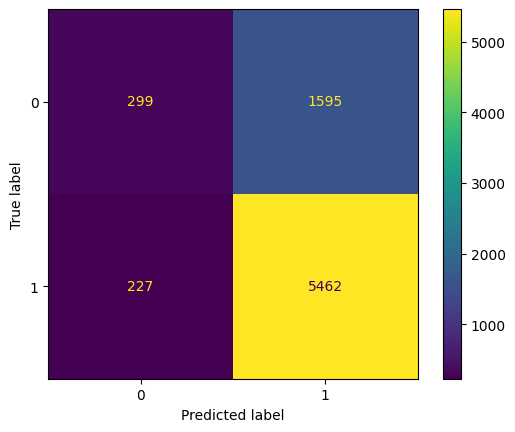

0.30 0.758 0.583


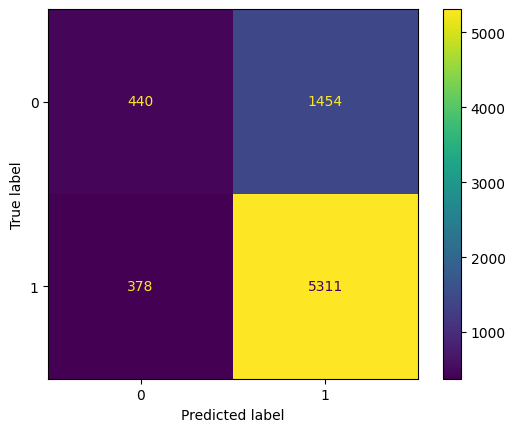

0.40 0.762 0.604


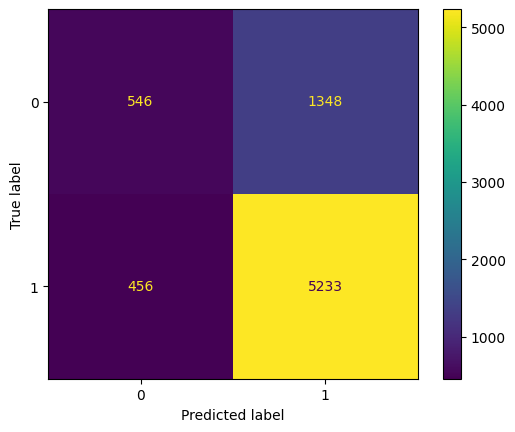

0.50 0.764 0.615


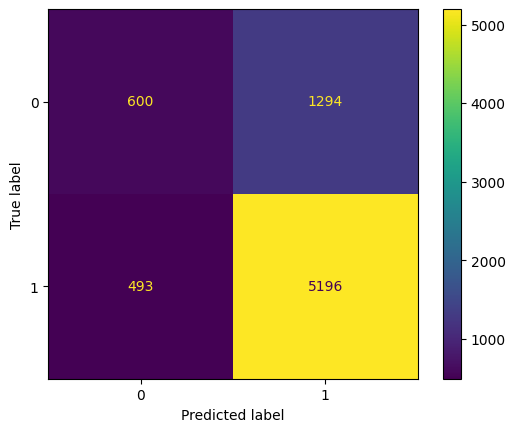

0.60 0.769 0.631


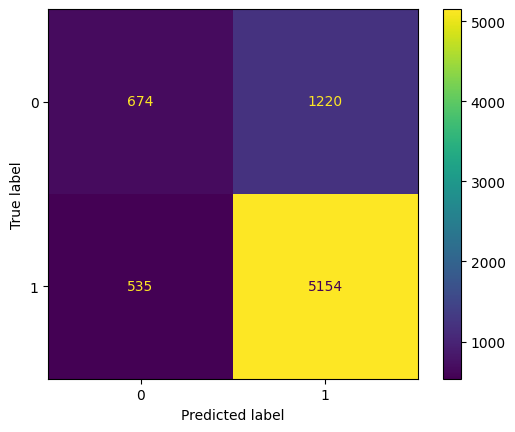

0.70 0.761 0.637


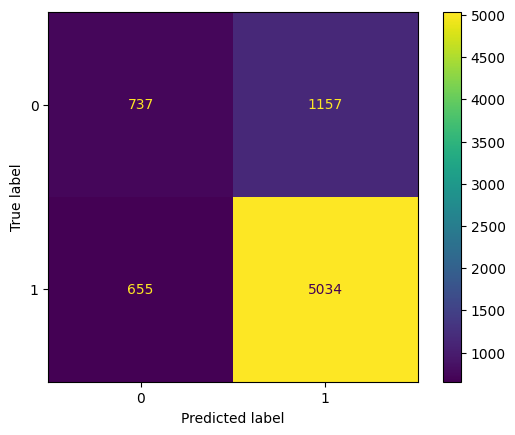

0.80 0.724 0.628


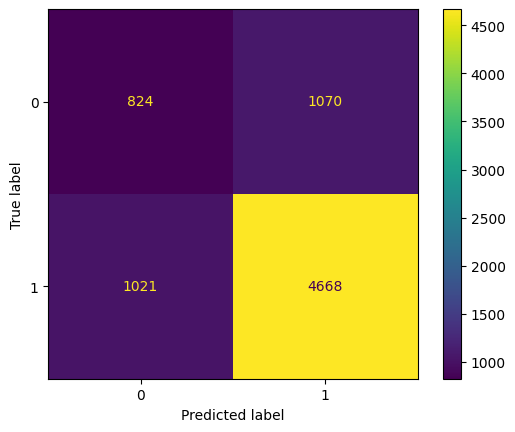

0.90 0.576 0.560


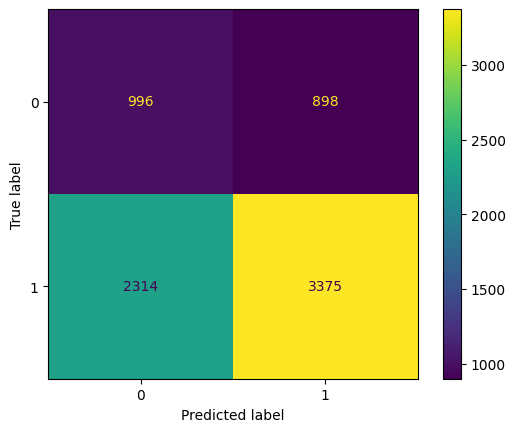

              precision    recall  f1-score   support

         0.0       0.57      0.16      0.25      1894
         1.0       0.77      0.96      0.86      5689

    accuracy                           0.76      7583
   macro avg       0.67      0.56      0.55      7583
weighted avg       0.72      0.76      0.70      7583



In [71]:
for i in np.arange(.2,1, .1):
    view(i, merged.annotated, merged.acc)
print(classification_report(merged.annotated, [x>.2 for x in merged.acc]))

# Video 5

In [72]:
merged = merge_annotations_real(5, 6378, "_output_cascade")
merged.head()

annotated
0.0    4453
1.0    1925
Name: count, dtype: int64


,frame,acc,annotated
0,2,0.261932,1.0
1,12,0.234186,1.0
2,13,0.266573,1.0
3,15,0.206249,1.0
4,16,0.213829,1.0


In [73]:
# auf etwa der Hälfte der Frames wurde ein Gesicht gefunden.
density(merged)

3657 6370


'Auf 57.41% der Frames wurde ein Gesicht gefunden.'

In [74]:
get_df_accs(merged)


,threshold,accuracy,balanced_acc
0,0.20,0.403610,0.449609
1,0.25,0.414821,0.432939
2,0.30,0.431228,0.429625
3,0.35,0.463221,0.438651
4,0.40,0.503965,0.462102
5,0.45,0.540334,0.481053
6,0.50,0.566311,0.493786
7,0.55,0.598031,0.509838
8,0.60,0.629751,0.526293
9,0.65,0.651080,0.534520


0.20 0.404 0.450


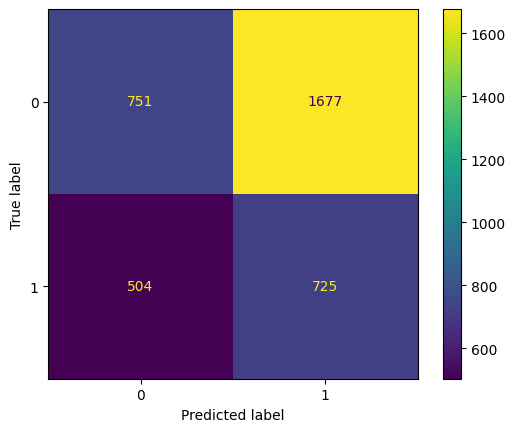

0.25 0.415 0.433


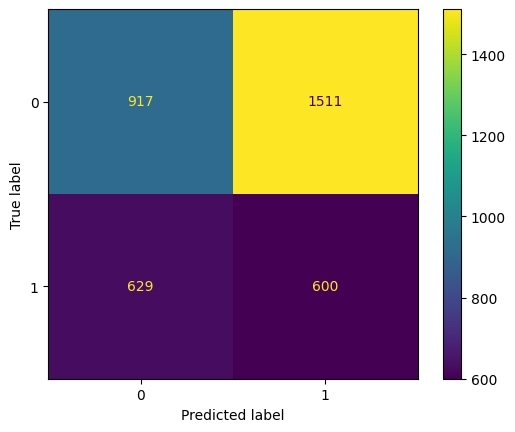

0.30 0.431 0.430


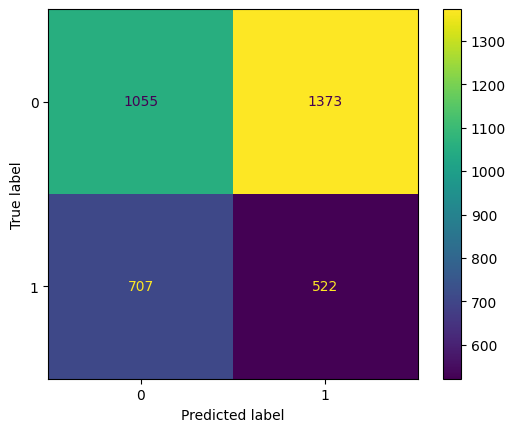

0.35 0.463 0.439


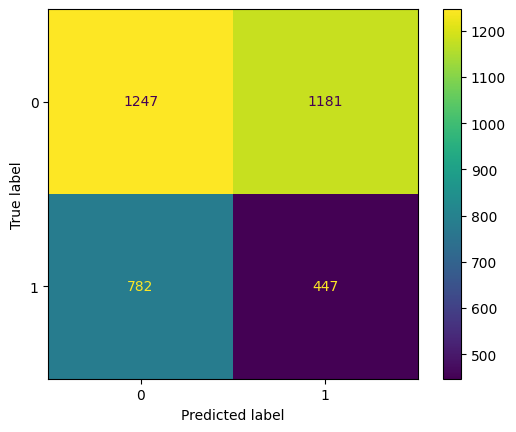

0.40 0.504 0.462


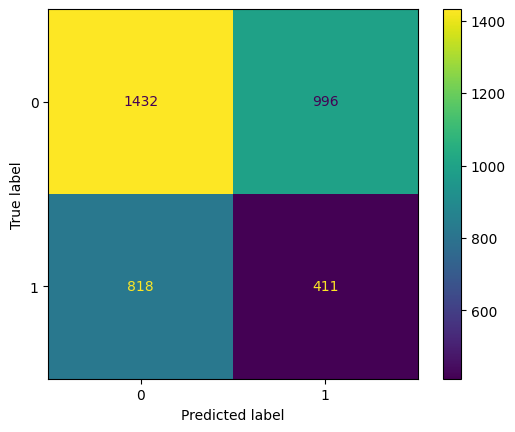

0.45 0.540 0.481


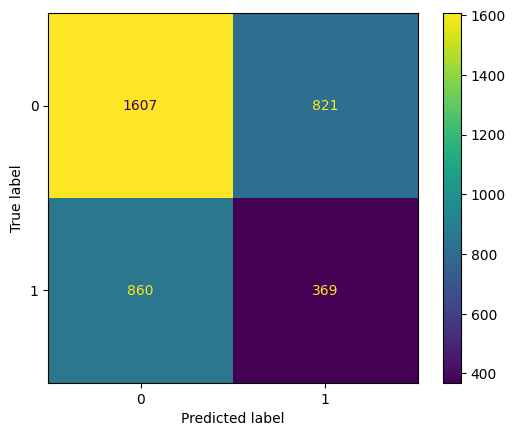

0.50 0.566 0.494


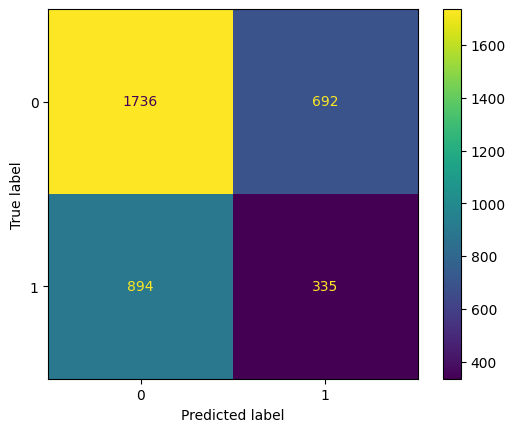

0.55 0.598 0.510


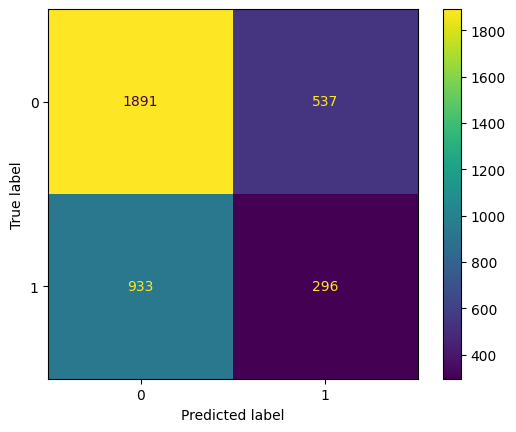

0.60 0.630 0.526


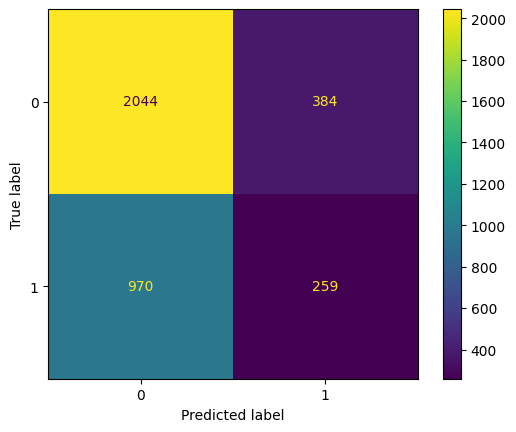

0.65 0.651 0.535


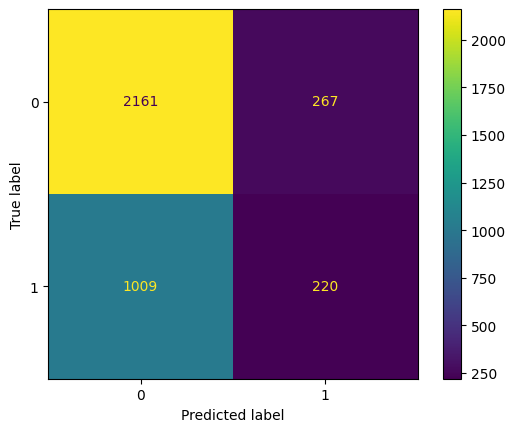

0.70 0.665 0.539


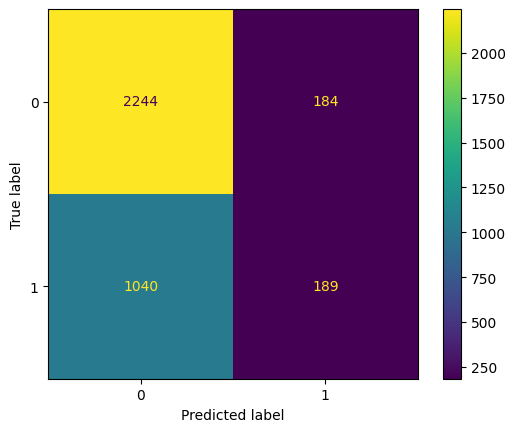

0.75 0.679 0.545


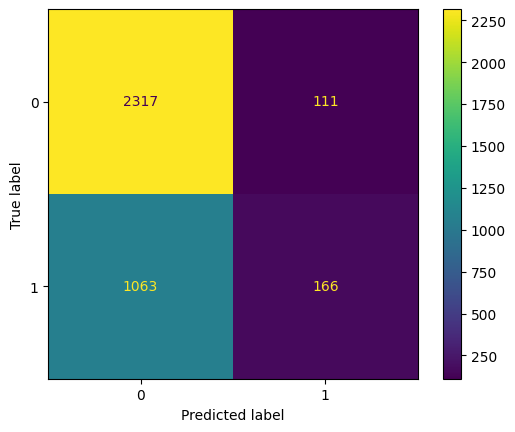

0.80 0.684 0.544


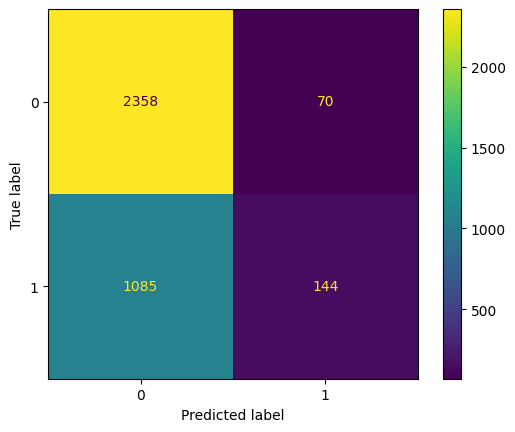

0.85 0.684 0.541


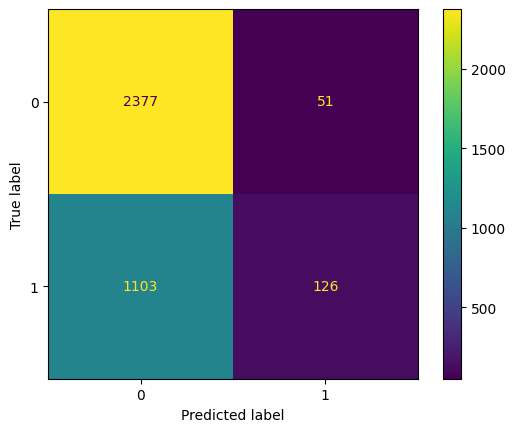

0.90 0.678 0.526


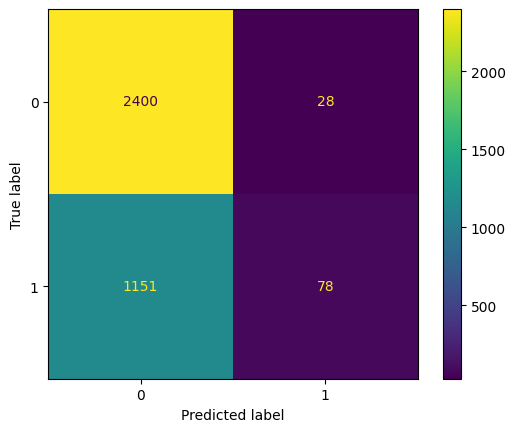

0.95 0.669 0.508


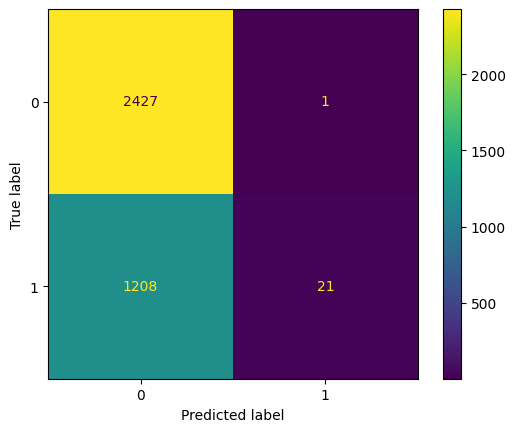

In [75]:
for i in np.arange(.2,1,.05):
    view(i, merged.annotated, merged.acc)


In [76]:
print(classification_report(merged.annotated, [x>.2 for x in merged.acc]))

              precision    recall  f1-score   support

         0.0       0.60      0.31      0.41      2428
         1.0       0.30      0.59      0.40      1229

    accuracy                           0.40      3657
   macro avg       0.45      0.45      0.40      3657
weighted avg       0.50      0.40      0.40      3657



# Test